# Bow river above Banff
In this exercise you will run different setups of the Structure for Unifying Multiple Modelling Alternatives (SUMMA; Clark et al., 2015a,b) for part of the Bow river in Alberta, Canada. Each setup is a different way in which the modelling domain can be discretized. You will investigate the impact of the choice of spatial discretization on streamflow simulations for this region. The map below gives an impression of the size and elevation gradiants in this catchment. The red circle indicates the catchment's outlet. (Sub-)catchment boundaries are taken from the MERIT Hydro dataset (Yamazaki et al., 2019). The Bow Valley contains several glaciers that strongly influence the regions streamflow generation. See Bash and Marshall (2014) for an introduction to glacier melt contributions in the Bow valley and Naz et al. (2014) for an example of glacier modelling.

<div>
<img src="./img/bow_at_banff.png" width="750"/>
</div>

### Note on pysumma
In the following, you might want to change certain values in your pysumma setup. Keep in mind that if you make these changes in the input files in the `settings` folder, you will need to make a new pysumma simulation object to have these changes take effect (`s = ps.Simulation(executable, file_manager_constant)`). If you instead make the changes to an existing pysumma simulation object, make sure to reset your pysumma simulation object to its base state after each simulation (`s.reset()`) so that your changes don't accumulate. 

## References
Bash, E., & Marshall, S. (2014). Estimation of glacial melt contributions to the Bow River, Alberta, Canada, using a radiation-temperature melt model. Annals of Glaciology, 55(66), 138-152. doi:10.3189/2014AoG66A226

Clark, M. P., J. Hendrikx, A. G. Slater, D. Kavetski, B. Anderson, N. J. Cullen, T. Kerr, E. Orn Hreinsson, and R. A. Woods (2011), Representing spatial variability of snow water equivalent in hydrologic and land-surface models: A review, Water Resour. Res., 47, W07539, doi:10.1029/2011WR010745

Clark, M. P., Nijssen, B., Lundquist, J. D., Kavetski, D., Rupp, D. E., Woods, R. A., … Rasmussen, R. M. (2015a). A unified approach for process-based hydrologic modeling: 1. Modeling concept. Water Resources Research, 51(4), 2498–2514. https://doi.org/10.1002/2015WR017198

Clark, M. P., Nijssen, B., Lundquist, J. D., Kavetski, D., Rupp, D. E., Woods, R. A., … Marks, D. G. (2015b). A unified approach for process-based hydrologic modeling: 2. Model implementation and case studies. Water Resources Research, 51, 2515–2542. https://doi.org/10.1002/2015WR017200

Naz, B. S., Frans, C. D., Clarke, G. K. C., Burns, P., and Lettenmaier, D. P. (2014). Modeling the effect of glacier recession on streamflow response using a coupled glacio-hydrological model, Hydrol. Earth Syst. Sci., 18, 787–802, https://doi.org/10.5194/hess-18-787-2014

Mizukami, N., Clark, M. P., Sampson, K., Nijssen, B., Mao, Y., McMillan, H., Viger, R. J., Markstrom, S. L., Hay, L. E., Woods, R., Arnold, J. R., and Brekke, L. D. (2016). mizuRoute version 1: a river network routing tool for a continental domain water resources applications, Geosci. Model Dev., 9, 2223–2238, https://doi.org/10.5194/gmd-9-2223-2016

Yamazaki, D., Ikeshima, D., Sosa, J., Bates, P. D., Allen, G. H., & Pavelsky, T. M. (2019). MERIT Hydro: a high‐resolution global hydrography map based on latest topography dataset. Water Resources Research, 55, 5053–5073. https://doi.org/10.1029/2019WR024873

<br>

## Notebook setup

In [2]:
# modules
import os
import time
import subprocess # needed to run mizuRoute.exe from the notebook
import numpy as np
import xarray as xr
import pysumma as ps
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
# define the base path so that we won't have to type this over and over
path_base = os.getcwd()
path_base

'/Users/pdas47/courses/cewa564/cewa564_bow'

<br>

## Load the simulations from Hydroshare
Simulations for this exercise have already been prepared and are available as a Hydroshare resource. Code to run SUMMA and perform the routing is available at the end of this notebook for those who are interested to try this out themselves. Note that the distributed simulations can take over an hour to complete, which is why these simulations are already prepared for your use. Execute the following commands to load the simulations from Hydroshare.

In [7]:
# modules
from hs_restclient import HydroShare # to get the files
import zipfile # and to unzip them

In [8]:
# Make a hydroshare object - note: needs authentication
hs = HydroShare()

Username:  pdas47@uw.edu
Password for pdas47@uw.edu:  ···········


In [9]:
# Specify the resource ID and download the resource into the main exercise directory
resource_id = 'a0cfaa6df18643ccbf777c9e3cdd8a86'
hs.getResource(resource_id, 
               destination=path_base)

HydroShareHTTPException: Received status 401 {"detail":"Invalid username/password."} when accessing https://www.hydroshare.org/hsapi/resource/a0cfaa6df18643ccbf777c9e3cdd8a86/ with method GET.

In [11]:
# unzip the file 
with zipfile.ZipFile(resource_id+'.zip', 'r') as zip_ref:
    
    # find all files in the zip
    zip_files = zip_ref.namelist()
    
    # loop over the files and extract only the .nc
    for zip_file in zip_files:
        if zip_file.endswith('.nc'):
            
            # print
            print('Now extracting ' + zip_file)
            
            # extract the file
            zip_ref.extract(zip_file,'tmp_zip')
            
            # find where the file is inside tmp_zip
            for root, dirs, files in os.walk('./tmp_zip'):
                for file in files:
                    old_loc = os.path.join(root,file)
                    old_folder = root
                    
            # specify where it should go
            new_folder = '.' + old_folder[old_folder.find('/output/'):]
            new_loc = '.' + old_loc[old_loc.find('/output/'):]
            
            # make the output directory if it doesn't exist yet
            if not os.path.exists(new_folder):
                os.makedirs(new_folder)
            
            # Take the file out of the temporary folder and put it where it shoule go
            os.rename(old_loc,new_loc)

Now extracting a0cfaa6df18643ccbf777c9e3cdd8a86/data/contents/output/bow/lumped_elevationBands/bow_lumped_elev_default_timestep.nc
Now extracting __MACOSX/a0cfaa6df18643ccbf777c9e3cdd8a86/data/contents/output/bow/lumped_elevationBands/._bow_lumped_elev_default_timestep.nc
Now extracting a0cfaa6df18643ccbf777c9e3cdd8a86/data/contents/output/bow/distributed/bow_distributed_routed.nc
Now extracting __MACOSX/a0cfaa6df18643ccbf777c9e3cdd8a86/data/contents/output/bow/distributed/._bow_distributed_routed.nc
Now extracting a0cfaa6df18643ccbf777c9e3cdd8a86/data/contents/output/bow/distributed/bow_distributed_default_timestep.nc
Now extracting __MACOSX/a0cfaa6df18643ccbf777c9e3cdd8a86/data/contents/output/bow/distributed/._bow_distributed_default_timestep.nc
Now extracting a0cfaa6df18643ccbf777c9e3cdd8a86/data/contents/output/bow/distributed_elevationBands/bow_distributed_elev_default_timestep.nc
Now extracting __MACOSX/a0cfaa6df18643ccbf777c9e3cdd8a86/data/contents/output/bow/distributed_elevat

In [12]:
# remove the file and the tmp_zip dir
!rm -r 'a0cfaa6df18643ccbf777c9e3cdd8a86.zip'
!rm -r './tmp_zip/'

<br>

## Spatial discretization
Now that all results are in, let's take take a look at the different modelling domains that generated the results. The four different spatial discretization setups are:
- The catchment is treated as a single, lumped entity. In SUMMA terms, it consists of a single Geographical Response Unit (GRU)
- The catchment is treated as a single GRU, but subdivided into three Hydrological Response Units (HRUs) that represent different elevation bands
- The cachment is divided into 51 GRUs that represent different sub-catchments, based on the river network
- The catchment is divided into 51 sub-catchments (GRUs), where the GRUs are further subdivided into HRUs that represent different elevation bands

We'll vizualize this using the shapefiles (`.shp`) provided as part of the exercise data.

In [12]:
# Specify shape file locations
path_shp_lumped           = os.path.join(path_base, 'data/bow/topography/lumped/bow_lumped.shp')
path_shp_lumped_elev      = os.path.join(path_base, 'data/bow/topography/lumped_elevationBands/bow_lumped_elevation_zone.shp')
path_shp_distributed      = os.path.join(path_base, 'data/bow/topography/distributed/bow_distributed.shp')
path_shp_distributed_elev = os.path.join(path_base, 'data/bow/topography/distributed_elevationBands/bow_distributed_elevation_zone.shp')
path_shp_river_network    = os.path.join(path_base, 'data/bow/topography/river_network/bow_river_network_from_merit_hydro.shp')

In [13]:
# Load the shapes
shp_lumped      = gpd.read_file(path_shp_lumped)
shp_lumped_elev = gpd.read_file(path_shp_lumped_elev)
shp_dist        = gpd.read_file(path_shp_distributed)
shp_dist_elev   = gpd.read_file(path_shp_distributed_elev)
shp_network     = gpd.read_file(path_shp_river_network)

In [14]:
# make a helpful function that can be used to plot the data
def plot_cases(basin_shape,ax,title_string):
    
    vmin, vmax = 1380,3320 # [m]
    basin_shape.plot(ax=ax, column='hru_elev', facecolor='w', edgecolor='k', cmap='Greys_r', legend=True, vmin=vmin, vmax=vmax); # basin discretization
    shp_network.plot(ax=ax, linewidth=2, color=(66/255,203/255,245/255)); # river network (the same for all cases)
    ax.plot(-115.555,51.167,linestyle='None',marker='o',color='r',label='outlet') # outlet (the same for all cases)
    ax.legend()
    ax.set_title(title_string)
    
    for im in plt.gca().get_images():
        im.set_clim(vmin, vmax)
    
    return

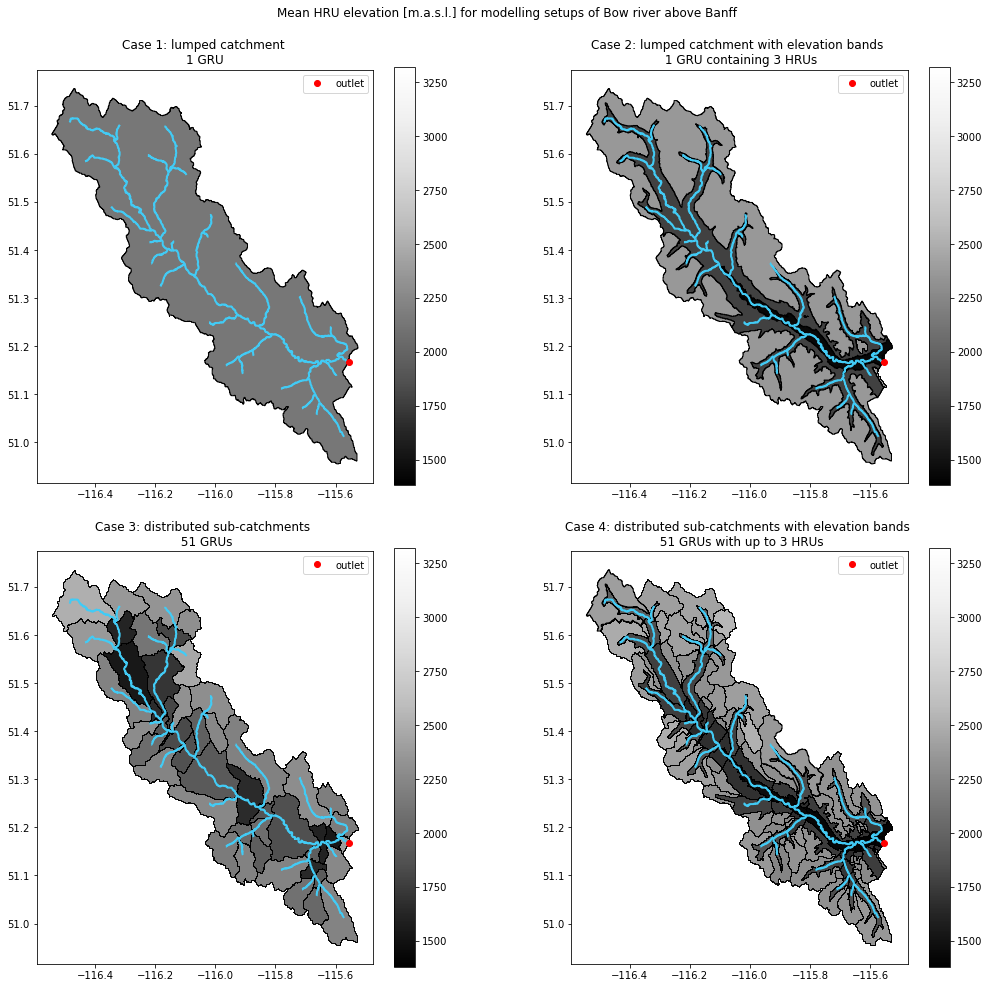

In [15]:
# Prepare a figure
fig, ax = plt.subplots(2,2,figsize=(14,14));
fig.tight_layout()
fig.suptitle('Mean HRU elevation [m.a.s.l.] for modelling setups of Bow river above Banff')
fig.subplots_adjust(top=0.92, wspace=0.27, hspace=0.15) # move stuff around a bit

# plot the 4 cases
plot_cases(shp_lumped,     ax[0,0],'Case 1: lumped catchment \n1 GRU')
plot_cases(shp_lumped_elev,ax[0,1],'Case 2: lumped catchment with elevation bands \n 1 GRU containing 3 HRUs')
plot_cases(shp_dist,       ax[1,0],'Case 3: distributed sub-catchments \n 51 GRUs')
plot_cases(shp_dist_elev,  ax[1,1],'Case 4: distributed sub-catchments with elevation bands \n 51 GRUs with up to 3 HRUs')

<br>

## Model analysis
We can do some initial analysis with the results that you already downloaded. You won't need to run the models for this exercise (although you can with the code in the second notebook if you want to), but the psyumma objects can be useful to access the parameter and attribute values for each model setup.

In [ ]:
# SUMMA.exe location
executable = 'summa.exe'

In [ ]:
# Define location of .exe and file manager
file_manager_lumped           = path_base + 'settings/bow/lumped/fileManager.txt'
file_manager_lumped_elev      = path_base + 'settings/bow/lumped_elevationBands/fileManager.txt'
file_manager_distributed      = path_base + 'settings/bow/distributed/fileManager.txt'
file_manager_distributed_elev = path_base + 'settings/bow/distributed_elevationBands/fileManager.txt'

In [ ]:
# Open pysumma simulations for both
s_lumped           = ps.Simulation(executable, file_manager_lumped)
s_lumped_elev      = ps.Simulation(executable, file_manager_lumped_elev)
s_distributed      = ps.Simulation(executable, file_manager_distributed)
s_distributed_elev = ps.Simulation(executable, file_manager_distributed_elev)

<br>
<br>

## Snow analysis
The spatial discretization of models affects the magnitude, timing and duration of the simulated snow pack and thus the magnitude, timing and duration of simulated streamflow. One way to visualize this is to plot the evolution of modelled Snow Water Equivalent (SWE) for each of the modelling elements in the four model setups (see Fig. 9 in Clark et al., 2011). SWE can be found in the SUMMA output `.nc` files as variable `scalarSWE`. As an example, code is provided that creates such a plot for cases 1 (lumped) and 2 (lumped with elevation bands).

#### SWE plot for the two lumped cases

In [6]:
# define the output paths
# -- SUMMA results
path_sim_lumped            = os.path.join(path_base, 'output/bow/lumped/bow_lumped_default_timestep.nc')
# path_sim_lumped_elev       = path_base + 'output/bow/lumped_elevationBands/bow_lumped_elev_default_timestep.nc'
# path_sim_distr             = path_base + 'output/bow/distributed/bow_distributed_default_timestep.nc'
# path_sim_distr_elev        = path_base + 'output/bow/distributed_elevationBands/bow_distributed_elev_default_timestep.nc'

# # -- mizuRoute results (contains streamflow only)
# path_sim_distr_routed      = path_base + 'output/bow/distributed/bow_distributed_routed.nc'
# path_sim_distr_elev_routed = path_base + 'output/bow/distributed_elevationBands/bow_distributed_elev_routed.nc'

In [7]:
# load the SUMMA simulations, we won't need the routing results for SWE analysis
sim_lumped      = xr.open_dataset(path_sim_lumped)
# sim_lumped_elev = xr.open_dataset(path_sim_lumped_elev)
# sim_distr       = xr.open_dataset(path_sim_distr)
# sim_distr_elev  = xr.open_dataset(path_sim_distr_elev)

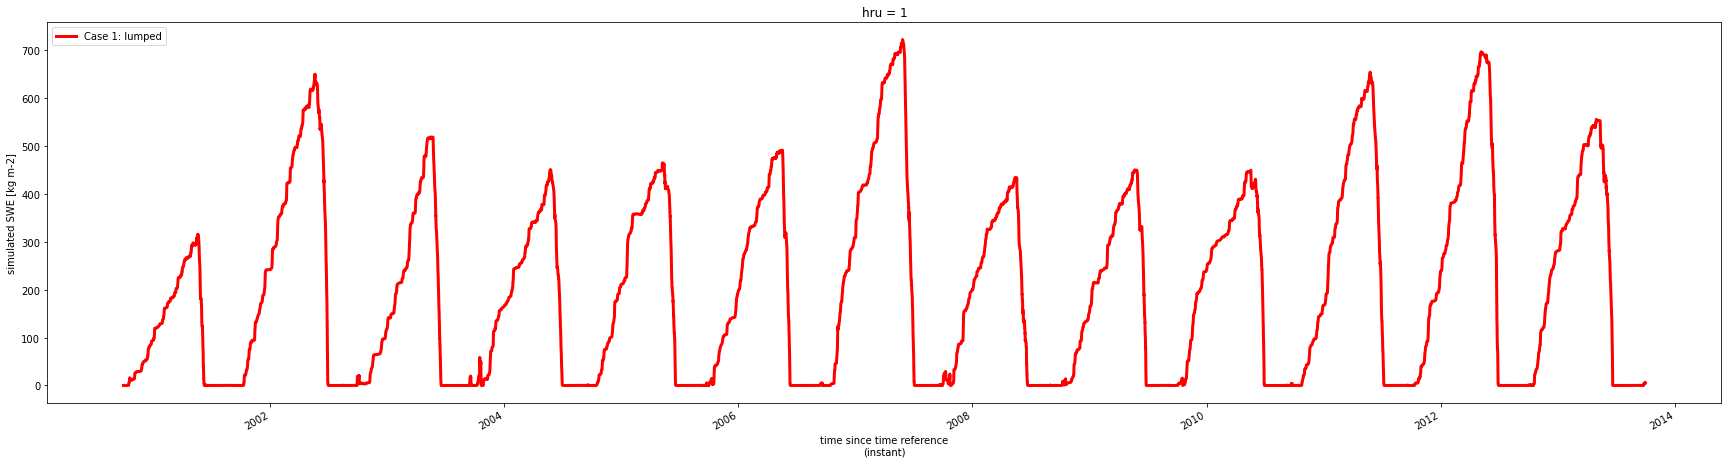

In [9]:
# make the plot
plt.figure(figsize=(30,7));

sim_lumped.scalarSWE.plot(color='r', label='Case 1: lumped', linewidth=3);
# sim_lumped_elev.scalarSWE.plot.line(x='time', color='grey'); # not plotting labels for these helps with memory usage
# sim_lumped_elev.scalarSWE.mean(dim='hru').plot(color='b', label='Case 2: average of elevation bands (individual bands in grey)', linewidth=3)

plt.legend(loc='upper left'); # forcing the legend in a specific location helps with memory usage
plt.ylabel('simulated SWE [kg m-2]');

<br>
<br>

## Streamflow analysis
The flow regime in the Bow river is predominantly melt-driven, and as such the spatial discretization of the model that affects magnitude, timing and duration of SWE simulations also affects the magnitude, timing and duration of streamflow simulations. Simulated streamflow for the four model setups can be accessed as follows:
- Case 1, lumped: as variable `averageRoutedRunoff` in the model output `.nc` file, with units `[m s-1]`
- Case 2, lumped + elevation zones: as variable `averageRoutedRunoff` in the model output `.nc` file, with units `[m s-1]`
- Case 3: distributed: as variable `IRFroutedRunoff` in the routing output `.nc` file, with units `[m3 s-1]`
- Case 4: distributed + elevation zones: as variable `IRFroutedRunoff` in the routing output `.nc` file, with units `[m3 s-1]`

Due to the differences in spatial discretization, some further details about these streamflow simulations are needed. For the distributed cases we ran a separate routing model (mizuRoute) to combine the output from the individual HRUs. We won't do that here, but the output is provided to you in the output directories for Cases 3 and 4:
- Case 1, lumped: this single runoff time series is assumed to be from the basin outlet (and is for all intents and purposes identical to that in `scalarRunoffTotal`).
- Case 2, lumped + elevation zones: time series of runoff for each of the three HRUs are assumed to flow into the unresolved river network (i.e. the river network smaller than the resolution for which we use mizuRoute for routing) and are routed internally with a Unit Hydrograph approach. This results in a single runoff time series for the GRU (i.e. the combination of the three HRUs).
- Case 3, distributed: the routing model mizuRoute provides routed streamflow for each reach in the river network. The reach at the outlet has `reachID = 71028585`.
- Case 4, distributed + elevation zones: see Case 2 and 3. Within-GRU routing is done within SUMMA; routing between GRUs is handled by mizuRoute, a separate routing model which we will not run here.
